In [1]:
import torch
import numpy as np
# import matplotlib.pyplot as plt

# from datasets import get_dataset
#from basics import train, get_data, accuracy
from basics import get_data
from extensions import ExtendedData
# from torch_geometric.datasets import StochasticBlockModelDataset
# from synthetic_data import SBM
from nett import sample_dcsbm
# import torch_geometric.utils 

from torch_geometric.data import Data
from sklearn.datasets import make_blobs
# from optimize import evaluate_model, evaluate_params

torch.manual_seed(123)

# import platform
# platform.system()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plot_net = False

n = 300 # change to 600, 1200
# Create a symmetric tensor with p on the diagonal and q off diagonal

p = 0.015
q = 0.002
K = 3

# Create a tensor filled with q
B = torch.full((K, K), q)
# Fill the diagonal with p
for i in range(K):
    B[i, i] = p

# B = B * 0.2
# data = StochasticBlockModelDataset('data/SBM', [n//3, n//3, n//3], B, num_channels=3, class_sep=.1)[0]
# data = SBM('data/SBM', [n//3, n//3, n//3], B, num_channels=3, class_sep=2)[0]

X, y, centers = make_blobs(
    n_samples=n,
    n_features=K,
    centers=K,
    cluster_std=10,
    random_state=42,
    return_centers=True  # Set this to True to return centersor n =600 SBM
)

data = Data(edge_index = sample_dcsbm(y, B), x = torch.tensor(X).float(), y = torch.tensor(y).long())

# data = get_data('squirrel')

data = ExtendedData.from_dict(data.to_dict())
data.create_masks('balanced')
data.to(device)
# print data's device
print(data.get_device())

# Print mean degree
print(torch.mean(data.get_degrees()))


# performance of the Bayes classifier
from sklearn.metrics import accuracy_score

# Function to find the closest center for each point in X
def predict_labels(X, centers):
    distances = torch.cdist(X, torch.tensor(centers).float())
    closest_center = torch.argmin(distances, dim=1)
    return closest_center

# Calculate accuracy for each test split and report the average
def evaluate_bayes_classifier(data, centers):
    test_masks = data.masks['test']
    accuracies = []

    for i in range(test_masks.shape[1]):
        test_mask = test_masks[:, i]
        X_test = data.x[test_mask]
        y_test = data.y[test_mask]
        y_pred = predict_labels(X_test, centers)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        # print(f'Test Accuracy for split {i+1}: {accuracy:.4f}')
    return  np.mean(accuracies), np.std(accuracies)

# Evaluate the Bayes classifier
avg_acc, std_acc = evaluate_bayes_classifier(data, centers)
print(f'\n---\nAverage Test Accuracy (Optimal): {avg_acc:.4f} ± {std_acc:.3f}')

data.plot_features_3d(use_svd=True)


cpu
tensor(2.1200, dtype=torch.float64)

---
Average Test Accuracy (Optimal): 0.6433 ± 0.039


In [2]:
if plot_net:
    # !pip install git+https://github.com/aaamini/graph_visualizer.git
    from graph_visualizer import visualize_graph

    # Visualize the graph
    visualize_graph(data)


In [3]:
from tqdm import tqdm
import numpy as np
import torch

# from np_gnn.models import NPGNN
from model_interfaces import ACM_GCNP, NPGNN_AB
from basics import train_model_class
from kernels import *

torch.manual_seed(42)

models = [{'model_class': NPGNN_AB, 'hyper_params': 
           {'spec_train': True, 
            # 'kern_fn': sobolev_cmpct(-1,1), 
            # 'kern_fn': sobolev_reals(.5), 
            'kern_fn': gaussian_rbf(.52),
            'norm': False, 
            'shift': False, 
            'pct': 1,
            'use_sqrt_K':False}},
          {'model_class': ACM_GCNP, 'hyper_params': {'dropout': 0.5}}]


lr = 1e-2
wd = 5e-4
# nreps = data.masks['train'].shape[1]
nreps = 5
n_iter = 1500
record_models = True  # Set this flag to True if you want to record the trained models

val_results = {model['model_class'].__name__: [] for model in models}
tst_results = {model['model_class'].__name__: [] for model in models}
trained_models = {model['model_class'].__name__: [] for model in models} if record_models else None

for rep in tqdm(range(nreps), desc='Training Repetitions'):
    tqdm.write(f"Rep {rep + 1}/{nreps}")
    for model in models:
        model_class = model['model_class']
        hyper_params = model['hyper_params']
        best_acc, test_acc, iterations, trained_model = train_model_class(
            model_class, hyper_params, data, rep, n_iter, lr, wd
        )

        val_results[model_class.__name__].append(best_acc)
        tst_results[model_class.__name__].append(test_acc)
        if record_models:
            trained_models[model_class.__name__].append(trained_model)
        # print model result indented under repetition info
        tqdm.write(f"    {model_class.__name__} - val = {best_acc:.3f}, tst = {test_acc:.3f}, # iter = {iterations + 1:4d}")

# Calculate and print mean and standard deviation for each model
for model in models:
    model_name = model['model_class'].__name__
    mean_val = np.mean(val_results[model_name])
    std_val = np.std(val_results[model_name])
    mean_tst = np.mean(tst_results[model_name])
    std_tst = np.std(tst_results[model_name])
    tqdm.write(f"\n{model_name} - mean val = {mean_val:.3f} ± {std_val:.3f}, mean tst = {mean_tst:.3f} ± {std_tst:.3f}")

# if record_models:
#     # Save the trained models to disk or handle them as needed
#     for model_name, models in trained_models.items():
#         for i, model in enumerate(models):
#             torch.save(model.state_dict(), f"{model_name}_rep_{i + 1}.pt")
#             tqdm.write(f"Saved {model_name} model from rep {i + 1}")# Evaluate the Bayes classifier




Training Repetitions:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 1/5
tensor(True)


Training Repetitions:   0%|          | 0/5 [00:00<?, ?it/s]

    NPGNN_AB - val = 0.817, tst = 0.683, # iter =  451


Training Repetitions:  20%|██        | 1/5 [00:01<00:04,  1.19s/it]

    ACM_GCNP - val = 0.817, tst = 0.717, # iter =  272
Rep 2/5
tensor(True)
    NPGNN_AB - val = 0.817, tst = 0.800, # iter =  414


Training Repetitions:  40%|████      | 2/5 [00:02<00:03,  1.26s/it]

    ACM_GCNP - val = 0.867, tst = 0.800, # iter =  335
Rep 3/5
tensor(True)
    NPGNN_AB - val = 0.883, tst = 0.800, # iter =  301


Training Repetitions:  60%|██████    | 3/5 [00:03<00:02,  1.14s/it]

    ACM_GCNP - val = 0.900, tst = 0.833, # iter =  250
Rep 4/5
tensor(True)
    NPGNN_AB - val = 0.833, tst = 0.733, # iter =  352


Training Repetitions:  80%|████████  | 4/5 [00:04<00:01,  1.06s/it]

    ACM_GCNP - val = 0.850, tst = 0.683, # iter =  222
Rep 5/5
tensor(True)


Training Repetitions:  80%|████████  | 4/5 [00:04<00:01,  1.06s/it]

    NPGNN_AB - val = 0.817, tst = 0.717, # iter = 1500


Training Repetitions: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]

    ACM_GCNP - val = 0.883, tst = 0.800, # iter =  260

NPGNN_AB - mean val = 0.833 ± 0.026, mean tst = 0.747 ± 0.046

ACM_GCNP - mean val = 0.863 ± 0.029, mean tst = 0.767 ± 0.057


Text(0, 0.5, '$\\hat{f}(\\lambda)$')

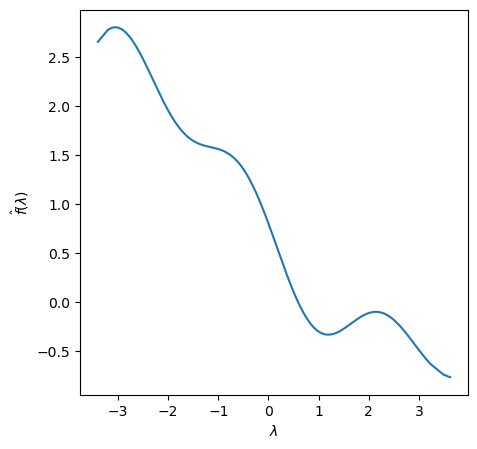

In [4]:
model = trained_models['NPGNN_AB'][0]

fh = model.K @ model.alpha

from np_gnn.models import get_network_matrix, get_spectral_decomp
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
# plot model.S
# A =  data.get_adjacency_matrix().to_dense()
# M = get_network_matrix(A, norm=False, shift=False, is_symm=True)
# U, S, Vh = get_spectral_decomp(M, is_symm=True)
# plt.plot(model.S.detach().numpy())
plt.figure(figsize=(5,5))
plt.plot(model.S.detach().numpy(), fh.detach().numpy())
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\hat{f}(\lambda)$')

In [5]:
# compute eigenvalues of B
torch.torch.linalg.eigh(B)[0]

tensor([0.0130, 0.0130, 0.0190])

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# count the number of parameters:
for model_name in ['NPGNN_AB', 'ACM_GCNP']:
    model = trained_models[model_name][0]
    print(f'{model_name}: {count_parameters(model)}')

    

NPGNN_AB: 312
ACM_GCNP: 22224


In [7]:
# from jacobi_conv.PolyConv import PolyConvFrame, JacobiConv
# model = PolyConvFrame(JacobiConv)
# all_ones = torch.ones(data.edge_index.shape[1], dtype=torch.float).to(device)
# model(data.x, data.edge_index, all_ones).shape

# acm_gcnp_model_inputs = ACM_GCNP.get_model_inputs(data)
# acm_gcnp_model = ACM_GCNP({'dropout':.5}).to(device)